In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights


# Download the following data set for the code to run:

- [Link](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg)
- After downloading, please make sure to include the zip file inside the directory of this notebook
    - Make sure the images are inside 2 subdirectories img_celeba/img_celeba



## Data exploration


In [2]:
# Define paths
base_dir = 'CelebA'
bbox_excel_path = os.path.join(base_dir, 'list_bbox_celeba.txt')
identity_txt_path = os.path.join(base_dir, 'identity_CelebA.txt')
images_dir = os.path.join(base_dir, 'img_celeba', 'img_celeba')

# Read the Excel file for bounding boxes
bbox_df = pd.read_csv(bbox_excel_path, sep='\s+', skiprows=1)

# Read the identity file
identity_df = pd.read_csv(identity_txt_path, sep=" ", header=None, names=['image_id', 'identity'])
# Path to the evaluation partition file
eval_partition_path = os.path.join(base_dir, 'list_eval_partition.txt')

# Read the evaluation partition file
eval_partition_df = pd.read_csv(eval_partition_path, delim_whitespace=True,
                                header=None, names=['image_id', 'evaluation_status'])

# Merge the evaluation partition data with the bounding boxes and identity data
merged_df = pd.merge(bbox_df, identity_df, on='image_id')
merged_df = pd.merge(merged_df, eval_partition_df, on='image_id')

# Split the merged data into training, validation, and testing datasets
train_df = merged_df[merged_df['evaluation_status'] == 0].drop(columns=['evaluation_status'])
val_df = merged_df[merged_df['evaluation_status'] == 1].drop(columns=['evaluation_status'])
test_df = merged_df[merged_df['evaluation_status'] == 2].drop(columns=['evaluation_status'])


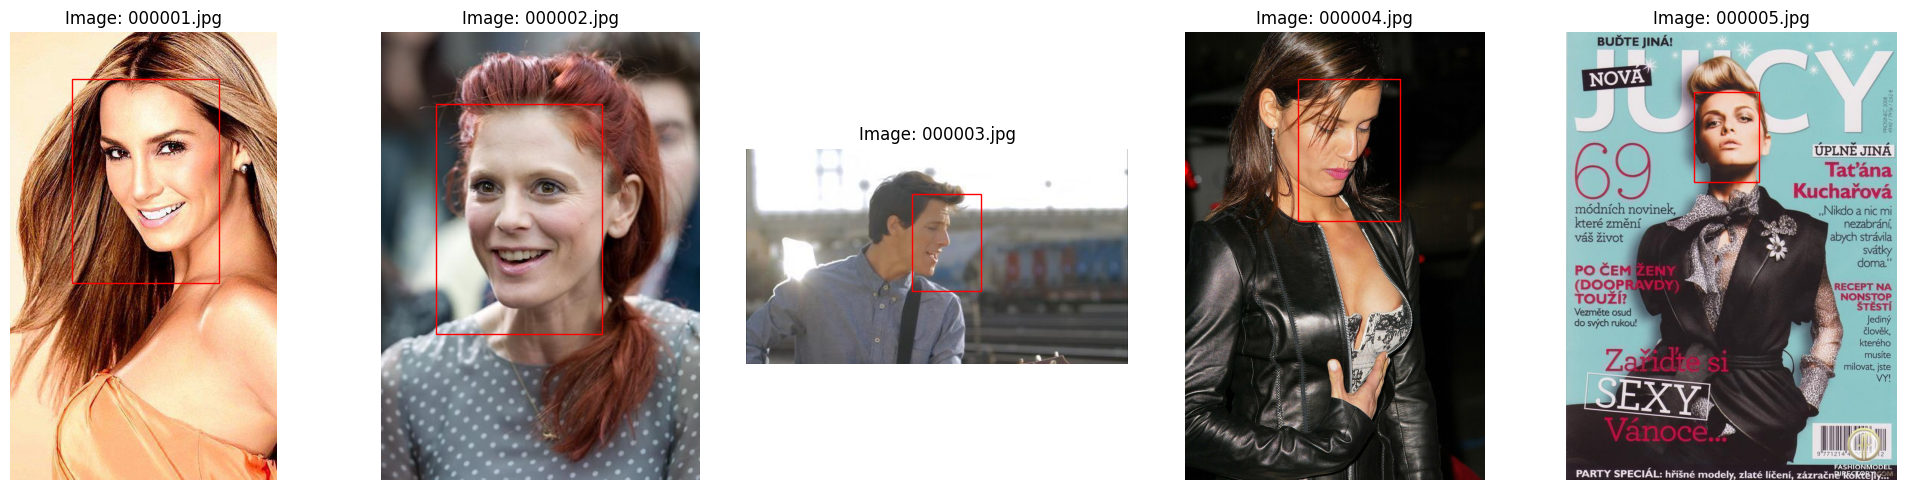

In [3]:
# Display first 5 images with bounding boxes and identity
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, row in merged_df.iterrows():
    if i >= 5:  # Only process the first 5 entries
        break
    img_path = os.path.join(images_dir, row['image_id'])
    img = Image.open(img_path)

    x = row['x_1']
    y = row['y_1']

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].imshow(img)
    axs[i].add_patch(rect)
    axs[i].set_title(f"Image: {row['image_id']}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
class CelebADataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        print("hello 1")
        img_name = os.path.join(self.images_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        bbox = self.dataframe.iloc[idx, 1:5].values.astype('float')
        identity = self.dataframe.iloc[idx, 5]

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'bbox': bbox, 'identity': identity}

        return sample

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Create instances of the dataset
train_dataset = CelebADataset(dataframe=train_df, images_dir=images_dir, transform=transform)
val_dataset = CelebADataset(dataframe=val_df, images_dir=images_dir, transform=transform)
test_dataset = CelebADataset(dataframe=test_df, images_dir=images_dir, transform=transform)


hello -1
hello -1
hello -1


In [7]:
# Create data loaders
batch_size = 32  # You can adjust this size as per your computational resources

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Validation Loading")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
print("Finished Test Loading")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Finished Train Loading")

Finished Validation Loading
Finished Test Loading
hello 0
hello 0
Finished Train Loading


In [8]:
class MultiTaskCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskCNN, self).__init__()
        # Load a pre-trained model as a feature extractor
        base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Exclude the last fc layer

        self.bbox_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, 4)  # 4 outputs for bbox (x, y, width, height)
        )

        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        bbox = self.bbox_head(x)
        class_logits = self.classifier_head(x)
        return bbox, class_logits


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
num_classes = len(train_df['identity'].unique())
model = MultiTaskCNN(num_classes=num_classes)
model = model.to(device)

bbox_loss_fn = nn.MSELoss().to(device)
class_loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [11]:
def evaluate_model(model, data_loader, criterion_bbox, criterion_class):
    model.eval()  # Set the model to evaluation mode
    total_bbox_loss = 0
    total_class_loss = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, bboxes, labels in data_loader:
            images = images.to(device)
            bboxes = bboxes.to(device)
            labels = labels.to(device)
            # Forward pass
            pred_bboxes, pred_labels = model(images)

            # Compute losses
            bbox_loss = criterion_bbox(pred_bboxes, bboxes)
            class_loss = criterion_class(pred_labels, labels)
            total_bbox_loss += bbox_loss.item()
            total_class_loss += class_loss.item()

    avg_bbox_loss = total_bbox_loss / len(data_loader)
    avg_class_loss = total_class_loss / len(data_loader)
    return avg_bbox_loss, avg_class_loss

In [12]:
train_dataset = CelebADataset(dataframe=train_df, images_dir=images_dir, transform=transform)
print(len(train_dataset))  # This should print a positive number

hello -1
hello 0
162770


In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(len(train_loader))  # This should also print a positive number, indicating batches


hello 0
hello 0
hello 0
5087


In [15]:
sample = train_dataset[1]  # Fetch the first item
print(sample)

hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
{'image': tensor([[[-0.9705, -0.8164, -0.6623,  ..., -0.3198, -0.2856, -0.2513],
         [-1.0904, -0.9363, -0.7822,  ..., -0.3712, -0.3027, -0.2171],
         [-1.1589, -1.0219, -0.8678,  ..., -0.3883, -0.3198, -0.2342],
         ...,
         [-0.7822, -0.7479, -0.7308,  ..., -0.0801, -0.1314, -0.1314],
         [-0.9020, -0.8335, -0.7822,  ..., -0.1999, -0.0287,  0.1597],
         [-0.9020, -0.8678, -0.8335,  ..., -0.1999,  0.2453,  0.4851]],

        [[-1.1253, -0.9853, -0.8452,  ..., -0.0399,  0.0476,  0.0826],
         [-1.2129, -1.0728, -0.9328,  ..., -0.1275,  0.0126,  0.0826],
         [-1.2479, -1.1253, -1.0028,  ..., -0.1975, -0.0574,  0.0476],
         ...,
         [-0.7577, -0.7227, -0.7052,  ...,  0.1352,  0.0126, -0.0049],
         [-0.8803, -0.8102, -0.7577,  ...,  0.0301,  0.1527,  0.3452],
         [-0.8803, -0.8452, -0.8102,  ...,  0.0301,  0.5028,  0.7304]],

        [[-0.9504, -0.8458, -0.7238,  ...,  0.2348

In [ ]:
for i, sample in enumerate(train_loader):
    print(f"Batch {i}: {sample['image'].shape}, {sample['bbox'].shape}, {sample['identity'].shape}")
    if i == 1:  # Just to test the first two batches
        break


In [ ]:
num_epochs = 3
train_bbox_losses = []
train_class_losses = []
val_bbox_losses = []
val_class_losses = []

for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    total_batches = len(train_loader)
    model.train()  # Set the model to training mode
    total_train_bbox_loss = 0
    total_train_class_loss = 0

    for batch_idx, (images, bboxes, labels) in enumerate(train_loader):
        print(f"Starting batch {batch_idx + 1}/{total_batches}")
        images = images.to(device)
        bboxes = bboxes.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        pred_bboxes, pred_labels = model(images)

        # Compute losses
        bbox_loss = bbox_loss_fn(pred_bboxes, bboxes)
        class_loss = class_loss_fn(pred_labels, labels)
        total_loss = bbox_loss + class_loss

        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()

        total_train_bbox_loss += bbox_loss.item()
        total_train_class_loss += class_loss.item()

    # Calculate average losses for the current epoch
    avg_train_bbox_loss = total_train_bbox_loss / len(train_loader)
    avg_train_class_loss = total_train_class_loss / len(train_loader)
    train_bbox_losses.append(avg_train_bbox_loss)
    train_class_losses.append(avg_train_class_loss)

    # Evaluate on the validation set
    avg_val_bbox_loss, avg_val_class_loss = evaluate_model(model, val_loader, bbox_loss_fn, class_loss_fn)
    val_bbox_losses.append(avg_val_bbox_loss)
    val_class_losses.append(avg_val_class_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train BBox Loss: {avg_train_bbox_loss:.4f}, '
          f'Train Class Loss: {avg_train_class_loss:.4f}, '
          f'Val BBox Loss: {avg_val_bbox_loss:.4f}, '
          f'Val Class Loss: {avg_val_class_loss:.4f}')


epoch 0
hello 0


In [ ]:

# Plotting the training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_bbox_losses, label='Train BBox Loss')
plt.plot(val_bbox_losses, label='Val BBox Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bounding Box Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_class_losses, label='Train Class Loss')
plt.plot(val_class_losses, label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss')
plt.legend()

plt.show()